<a href="https://colab.research.google.com/github/junh0o0/2024-capstone/blob/master/train_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

os.chdir('/content/drive/MyDrive/train_kobert')

In [3]:
from google.colab import output
!pip install -r requirements.txt
output.clear()

In [1]:
import numpy as np
np.__version__

'1.23.1'

In [5]:
import pandas as pd

In [2]:
import os
os.chdir('/content/drive/MyDrive/train_kobert')

In [3]:
from kobertt import BERTDataset,BERTClassifier,BERTSentenceTransform

In [6]:
df = pd.read_csv('train_set.csv')

In [7]:
df['polarity'].value_counts()

,count
polarity,
긍정,3516
부정,3516
중립,602


In [ ]:
! python run_train.py \
    --train_path='train_set.csv' \
    --max_len=64 \
    --batch_size=32 \
    --warmup_ratio=0.1 \
    --num_epochs=10 \
    --max_grad_norm=1 \
    --log_interval=200 \
    --learning_rate=5e-5 \
    --device=cuda

/content/drive/MyDrive/train_kobert/run_train.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('중립',int(2))
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/tra

In [ ]:
max_len=64
batch_size=32
warmup_ratio=0.1
num_epochs=5
max_grad_norm=1
log_interval=200
learning_rate=5e-5

In [ ]:
from kobertt import BERTDataset,BERTClassifier,BERTSentenceTransform
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import gluonnlp as nlp


In [ ]:
device = torch.device("cuda:0")

In [ ]:
def predict(test_df:pd.DataFrame):

  tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
  bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
  vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
  device = torch.device("cuda:0")

  model = torch.load('capstone.model')

  d = test_df['review']
  for predict_sentence in d:
    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()
    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model (token_ids, valid_length, segment_ids)

        for i in out:
          logits=i
          logits = logits.detach().cpu().numpy()

          if np.argmax(logits) == 0:
            print(predict_sentence, '부정')
          if np.argmax(logits) == 1:
            print(predict_sentence, '긍정')
          if np.argmax(logits) == 2:
            print(predict_sentence, '중립')



In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/train_kobert/revi.xlsx')

In [ ]:
df

,Unnamed: 0,asepct,review
0,0,편의성,여름철에 잘쓰고 있어요
1,1,편의성,"가볍고 귀엽네요 ㅎㅎㅎ 조립도 완전 간편하고, 충전해서 한번 해봤는데 바람세기도 조..."
2,2,소음,소음도 별로 안나서 더 좋아요.
3,3,색상,색도좋고요
4,4,무게,무게감도 있고
...,...,...,...
67,67,품질,나무랄데없었습니다
68,68,편의성,잘사용하고있어요 좋아요
69,69,사이즈,사이즈도 좋고
70,70,소음,조용하고


In [ ]:
predict(df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

<ipython-input-12-95965553df02>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('capstone.model')


model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

여름철에 잘쓰고 있어요 긍정
가볍고 귀엽네요 ㅎㅎㅎ 조립도 완전 간편하고, 충전해서 한번 해봤는데 바람세기도 조절가능하고 시원하네요~ 긍정
소음도 별로 안나서 더 좋아요. 긍정
색도좋고요 긍정
무게감도 있고 부정
토프그레이 색상도 예쁘고 디자인이 심플하면서 고급져 보입니다. 긍정
디자인이 심플하면서 고급져 보입니다. 긍정
선풍기 손잡이가 잡기 편하게 만들어져 잘만든 선풍기 같아요. 긍정
조용하고 시원합니다 긍정
조립이 쉬웠습니다 긍정
소음이 아예없진 않지만 선풍기 소리야 뭐 지금까지 불편함 없이 잘 써요. 중립
리모컨 있어 편해요 긍정
리모콘이 있어 넘 편해요 긍정
소음 없고 직관적인 패널로 사용하기 편리하다고 하시네요~ 긍정
색상도 너무 이뻐요 긍정
색상도 이쁨 긍정
더울 때 잘 사용했어요! 긍정
모터소음도 약간 있긴 해도 거슬릴 정도는 아니라서 조용하고 사용하기 좋습니다. 긍정
선풍기 색이나 디자인 모두 마음에 들고 긍정
여름 말에 잘 썼어요 최고 긍정
삼성께 역시좋아요 긍정
색도 이쁘고 다음에 추가 구매 예정입니다. 긍정
사용해보니 소음이 그렇게 크지 않아서 좋네요 긍정
타이머를 만지면 드드드 소리가나서 아예 안쓰네요ㆍ 부정
우선 디자인적으로 흰색이라 깔끔한 편이구요. 긍정
(약풍)임에도 엄청 시원한 느낌이었어요! 중립
아무쪼록 너무나 만족스럽게 잘 이용하고 있습니다 ㅎㅎ 긍정
컬러가 맘에들어요! 긍정
소음이 적고 부드럽게 잘 움직여서 좋아요. 긍정
색상이 맘에 들어 좋아요 긍정
사용을 못해봤어요. 너무 늦게사서 추워져서. . 부정
갑자기고장난 오래된놈은 버리고 급하게 구매했는데 시간없어서 품질가격소문? 확인후 빠르게구매 역시!좋음 긍정
소음이 있어 티브 볼때 신경 쓰여 아쉽지만, 부정
바닥, 몸통 다 튼튼해서 좋아요!! 긍정
우선 저렴한 가격이고 튼튼합니다. 긍정
저소음은 아니지만 바람세기도 만족스러워 나쁘지 않습니다. 긍정
저소음의 기준이 뭔지 모르겠지만 절대 저소음은 아닌 거 같아요 중립
더운 여름과 가을 늦 더위에 잘 사용했습니다 긍정
소음이 조금

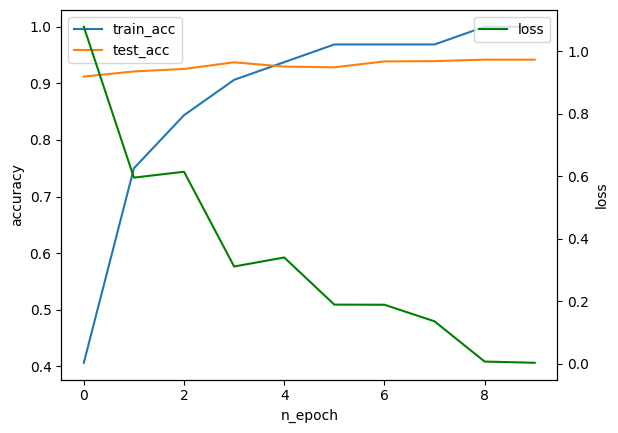

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(train_acc))

fig, ax1 = plt.subplots()
ax1.plot(x, train_acc)
ax1.plot(x,test_acc)
ax1.set_ylabel('accuracy')
ax1.set_xlabel('n_epoch')
ax1.legend(['train_acc','test_acc'])

ax2 = ax1.twinx()
ax2.plot(x,loss,color='g')
ax2.set_ylabel('loss')
ax2.legend(['loss'])
plt.show()